### Questions to answer:
1. What do the timing distributions look like?
2. How does AoS compare to SoA?
3. How does tuple size affect timing?
4. How does complexity affect timing?
5. How does access pattern affect timing?

## 1. What do the timing distributions look like? Do we see linearity through container size and number of iterations?

### Getting set up

First, we must load the dataframe. Additionally, we import our dataframe plotting library, aliased here as 'D'.

In [1]:
%matplotlib inline
import pandas as pd
df = pd.read_pickle('unpack_benchmark.dataframe')
import df_plot as D

First, we want to look at a timing distribution. To do this, we define a filter dictionary to constrain our dataframe:

In [2]:
filter_dict = {
    'access_pattern': 'independent',
    'complexity': 'complex',
    'column': 'nocolumn',
    'type': 'std::tuple<double, double, double, double>',
    'orientation': 'soa',
    'container_size': 32768,
    'iterations': 32768
}

Before we actually filter the dataset, we can take a look at the type of data which will be returned.

In [3]:
import df_plot as D
import pprint
pp = pprint.PrettyPrinter(indent=2)
unique = D.unique_set(df)
pp.pprint(D.get_selection_type(unique, filter_dict))

Querying with this filter will yield data with these dimensions unspecified:

{ 'benchmarking_tool': array(['chrono_benchmark'], dtype=object),
  'compiler': array(['g++-7.1'], dtype=object),
  'container': array(['vector'], dtype=object),
  'optimization': array(['O3'], dtype=object),
  'run_id': array(['1'], dtype=object),
  'system_memory': array(['64GB'], dtype=object),
  'system_os': array(['Red Hat Enterprise Linux Server 6.9 (Santiago)'], dtype=object),
  'system_processor': array(['Intel(R) Xeon(R) CPU E5-2680 @ 2.70GHz'], dtype=object)}


This looks ok. All of the free dimensions have array sizes of 1. This means we should get 1 dimensional timing data querying with this filter dict.

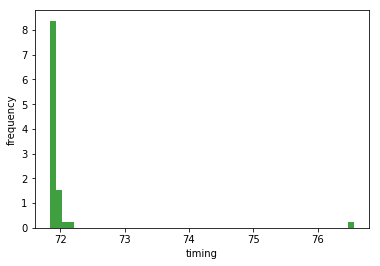

In [4]:
selection = D.filter_df(filter_dict, df)
D.histogram(selection, 'timing')

### Testing for linearity through iterations (single case)

x: [1, 32, 1024, 32768]
y: [0.09778025, 2.4766686, 73.359947, 2497.6101]
R2 score: 0.99999670
An R2 of 1 is a perfect fit. Range: (-infty, 1]
[ -1.44992140e+00   9.14280422e-01   7.65687388e+01   2.49751141e+03]


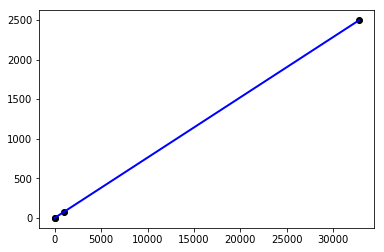

0.99999669929374169

In [5]:
filter_dict = {
    'access_pattern': 'independent',
    'complexity': 'complex',
    'column': 'nocolumn',
    'type': 'std::tuple<double, double, double, double>',
    'orientation': 'soa',
    'container_size': 1048576
}
selection = D.filter_df(filter_dict, df)
x, y = D.xy(selection, 'iterations', 'timing', sortx=True)
print('x: ' + str(x))
print('y: ' + str(y))
D.linearity_test(x, y, show_output=True)

This shows how linearity testing will work for each configuration. We'll now go through to verify that every configuration displays the same type of linearity.

### Testing for linearity through iterations (all configurations)

In [6]:
# this takes > an hour
# df_plot.linearity_test_all(unique, df, test_dimension='iterations') 

##### What this means...

Because all of these parameter configurations are showing an essentially perfect linear fit, we can proceed with analysis using only the highest iteration data points. These high iteration configurations will have the least noise and we won't lose any information from the lower iteration configurations.

### Testing for linearity through container size (single configuration)

Now that we've established we can look at solely the highest iteration data points, let's take a look at container size and verify we see the same type of linearity there.


x: [1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048, 4096, 8192, 16384, 32768]
y: [0.07234747, 0.14149547, 0.27709749, 0.56644583, 1.1007181, 2.1939662, 4.4165416, 8.7795639, 17.571589, 35.182793, 70.267639, 141.51245, 283.14798, 569.94684, 1183.4451, 2449.3101]
R2 score: 0.99956011
An R2 of 1 is a perfect fit. Range: (-infty, 1]
[ -5.92746475e+00  -5.85324549e+00  -5.70480696e+00  -5.40792990e+00
  -4.81417577e+00  -3.62666753e+00  -1.25165105e+00   3.49838191e+00
   1.29984478e+01   3.19985797e+01   6.99988434e+01   1.45999371e+02
   2.98000426e+02   6.02002536e+02   1.21000676e+03   2.42601519e+03]


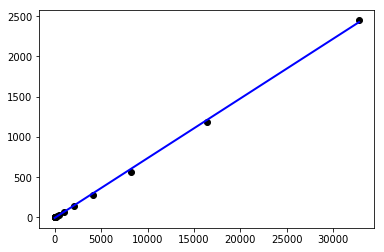

0.99956011129361877

In [7]:
filter_dict = {
    'access_pattern': 'independent',
    'complexity': 'complex',
    'column': 'nocolumn',
    'type': 'std::tuple<double, double, double, double>',
    'orientation': 'soa',
    'iterations': 1048576
}
selection = D.filter_df(filter_dict, df)
x, y = D.xy(selection, 'container_size', 'timing', sortx=True)
print('x: ' + str(x))
print('y: ' + str(y))
D.linearity_test(x, y, show_output=True)

### Testing for linearity through container size (all iterations)

In [8]:
# this takes > an hour
# df_plot.linearity_test_all(unique, df, test_dimension='container_size')

##### What this means...

We've now verified that we can do further analysis considering only the highest container size data points. 

## 2. How does AoS compare to SoA?

For this experiment, we'll use iterations per second as a sort of timing normalizer so we can better compare varying parameter configurations.

#### How they're affected by tuple size

{'soa': {'x': [1, 2, 4, 8], 'y': [52.765556, 88.750084, 67.265747, 68.709785]}, 'aos': {'x': [1, 2, 4, 8], 'y': [53.96986, 82.907639, 319.79721, 142.1256]}}


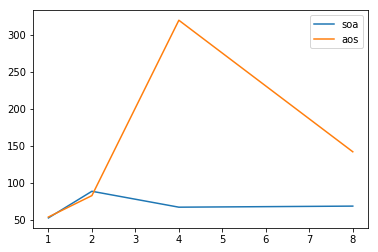

In [9]:
# need this to get the experiment's filter set
must_haves = {
    'container_size': 1048576,
    'access_pattern': 'single',
    'complexity': 'simple',
    'column': 'nocolumn',
    'iterations': 32768
}
let_vary = ['orientation']
filter_dicts = D.experiment_filter_dicts(unique, must_haves, let_vary)
allowed_types = D.make_tuple_types(['int'], [1,2,4,8])
filter_dicts = D.constrain_types(filter_dicts, allowed_types)
selection = D.multi_filter_df(filter_dicts, df)
selection = D.numeric_types(selection)
multi_xy = D.multi_xy(selection, 'type', 'timing', 'orientation', sortx=True)
print(multi_xy)
D.multi_line_plot(multi_xy)

#### How they're affected by access pattern

{'soa': {'x': ['combined', 'independent', 'single'], 'y': [843.90063, 866.22931, 67.265747]}, 'aos': {'x': ['combined', 'independent', 'single'], 'y': [427.30569, 443.70343, 319.79721]}}


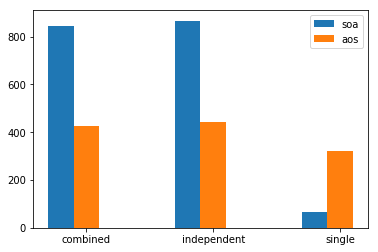

In [10]:
must_haves = {
    'container_size': 1048576,
    'complexity': 'simple',
    'column': 'nocolumn',
    'iterations': 32768,
    'type': 'std::tuple<int, int, int, int>'
}
let_vary = ['orientation', 'access_pattern']
filter_dicts = D.experiment_filter_dicts(unique, must_haves, let_vary)
selection = D.multi_filter_df(filter_dicts, df)
multi_xy = D.multi_xy(selection, 'access_pattern', 'timing', 'orientation', sortx=True)
print(multi_xy)
D.multi_bar(multi_xy)

#### How they're affected by complexity

[{'system_os': 'Red Hat Enterprise Linux Server 6.9 (Santiago)', 'system_processor': 'Intel(R) Xeon(R) CPU E5-2680 @ 2.70GHz', 'system_memory': '64GB', 'compiler': 'g++-7.1', 'optimization': 'O3', 'benchmarking_tool': 'chrono_benchmark', 'container': 'vector', 'type': 'std::tuple<int, int, int, int>', 'access_pattern': 'single', 'column': 'nocolumn', 'container_size': 1048576, 'iterations': 32768}]
{'soa': {'x': ['complex', 'simple'], 'y': [154.94151, 67.265747]}, 'aos': {'x': ['complex', 'simple'], 'y': [258.75592, 319.79721]}}


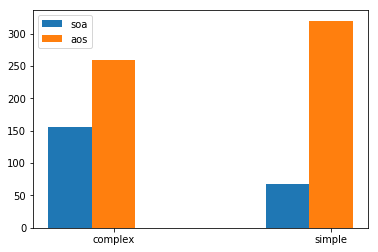

In [11]:
must_haves = {
    'access_pattern': 'single',
    'container_size': 1048576,
    'column': 'nocolumn',
    'iterations': 32768,
    'type': 'std::tuple<int, int, int, int>'
}
let_vary = ['orientation', 'complexity']
filter_dicts = D.experiment_filter_dicts(unique, must_haves, let_vary)
print(filter_dicts)
selection = D.multi_filter_df(filter_dicts, df)
multi_xy = D.multi_xy(selection, 'complexity', 'timing', 'orientation', sortx=True)
print(multi_xy)
D.multi_bar(multi_xy)

### 3. How does tuple size affect timing?

Here we can see what I think are effects from cache line sizes

{'int': {'x': [1, 2, 4, 8], 'y': [52.765556, 88.750084, 67.265747, 68.709785]}, 'char': {'x': [1, 4], 'y': [49.271606, 75.392082]}, 'double': {'x': [1, 2, 4, 8], 'y': [71.850609, 51.37072, 78.19384, 44.674389]}}


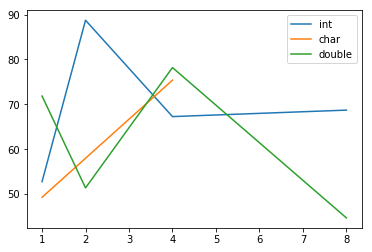

In [15]:
must_haves = {
    'container_size': 1048576,
    'access_pattern': 'single',
    'complexity': 'simple',
    'column': 'nocolumn',
    'iterations': 32768,
    'orientation': 'soa'
}
let_vary = []
filter_dicts = D.experiment_filter_dicts(unique, must_haves, let_vary)
allowed_types = D.make_tuple_types(['char', 'int', 'double'], [1,2,4,8])
filter_dicts = D.constrain_types(filter_dicts, allowed_types)
selection = D.multi_filter_df(filter_dicts, df)
selection = D.numeric_types(selection, add_type_bases=True)
multi_xy = D.multi_xy(selection, 'type', 'timing', 'type_base', sortx=True)
print(multi_xy)
D.multi_line_plot(multi_xy)